In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models as models
import os
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from IPython.display import Image

In [ ]:
model = models.resnet152(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
features_extractor = torch.nn.Sequential(*list(model.children())[:-1])

In [ ]:
preprocess =transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Orginal Image


In [ ]:
from PIL import Image

In [ ]:
image=Image.open("/content/drive/MyDrive/archive/Covid19-dataset/train/Covid/01.jpeg")

In [ ]:
 image.save("downloaded_image.jpg")

In [ ]:
original_image=Image.open("/content/drive/MyDrive/archive/Covid19-dataset/train/Covid/01.jpeg")

#Transformed Image for resnet152



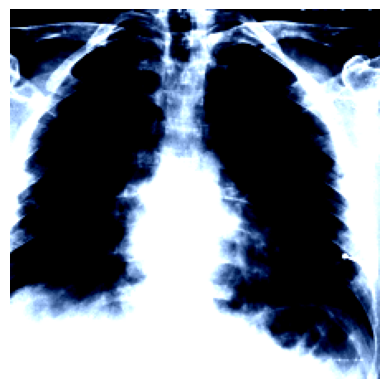

In [ ]:
transformed_image = preprocess(original_image)

# If you want to convert the transformed image tensor back to a NumPy array
transformed_image_np = transformed_image.numpy()

# If you want to display the transformed image using Matplotlib
import matplotlib.pyplot as plt

# Transpose the array to (height, width, channels) format
transformed_image_np = np.transpose(transformed_image_np, (1, 2, 0))

# Display the transformed image
plt.imshow(transformed_image_np)
plt.axis('off')  # Hide axes for better visualization
plt.show()
#Make sure to replace "path/to/your/image.jpg" with the actual file path of the image you want to transform. The preprocess pipeline applies resizing, center cropping, converting to a PyTorch tensor, and normalization to the input image. The transformed image can then be displayed or used for further processing in your deep learning models.


In [ ]:
files=os.listdir('/content/drive/MyDrive/archive/Covid19-dataset/train/Covid')

In [ ]:
def resnet_features(path):
  lst=[]
  files=os.listdir(path)
  for file in files:
    image = Image.open(path+'/'+file).convert('RGB')
    image=preprocess(image)
    image = image.unsqueeze(0)
    features = features_extractor(image)
    features = torch.flatten(features, start_dim=1)
    features_vector = features.detach().numpy().squeeze()
    features_vector=list(features_vector)
    lst.append(np.array(features_vector))
  return lst

In [ ]:
train_covid_features=resnet_features('/content/drive/MyDrive/archive/Covid19-dataset/train/Covid')
train_normal_features=resnet_features('/content/drive/MyDrive/archive/Covid19-dataset/train/Normal')
train_pneumonia_features=resnet_features('/content/drive/MyDrive/archive/Covid19-dataset/train/Viral_Pneumonia')

In [ ]:
test_covid_features=resnet_features('/content/drive/MyDrive/archive/Covid19-dataset/test/Covid')
test_normal_features=resnet_features('/content/drive/MyDrive/archive/Covid19-dataset/test/Normal')
test_pneumonia_features=resnet_features('/content/drive/MyDrive/archive/Covid19-dataset/test/Viral_Pneumonia')

In [ ]:
train_data_features=train_normal_features+train_covid_features+train_pneumonia_features
train_data_labels=[0]*len(train_normal_features)+[1]*len(train_covid_features)+[2]*len(train_pneumonia_features)
train_data={"image_features":train_data_features,'labels':train_data_labels}
train_data = pd.DataFrame(train_data)

In [ ]:
test_data_features=test_normal_features+test_covid_features+test_pneumonia_features
test_data_labels=[0]*len(test_normal_features)+[1]*len(test_covid_features)+[2]*len(test_pneumonia_features)
test_data={"image_features":test_data_features,'labels':test_data_labels}
test_data = pd.DataFrame(test_data)

In [ ]:
train_data = shuffle(train_data)
test_data = shuffle(test_data)

In [ ]:
train_data.head()

,image_features,labels
154,"[0.79645514, 0.50849295, 0.8640151, 0.4733112,...",1
174,"[0.7469258, 0.50035185, 0.92864984, 0.46636316...",1
150,"[0.82762253, 0.447479, 0.77093047, 0.44252196,...",1
27,"[0.7828166, 0.5167633, 0.83222157, 0.46741158,...",0
4,"[0.77481824, 0.5174459, 0.84001815, 0.47085252...",0


In [ ]:
test_data.head()

,image_features,labels
49,"[0.8236907, 0.49209517, 0.89646786, 0.40374437...",2
22,"[0.7494365, 0.47375306, 0.9765776, 0.49639076,...",1
47,"[0.8414277, 0.48609287, 0.9606855, 0.46232098,...",2
52,"[0.79912, 0.53662664, 0.8927149, 0.4702414, 0....",2
37,"[0.7480613, 0.44256094, 0.9546831, 0.4231871, ...",1


In [ ]:
X_train=train_data['image_features']
Y_train=train_data['labels']
X_train= np.vstack(X_train)
Y_train=np.vstack(Y_train)
Y_train=np.ravel(Y_train)

In [ ]:
X_test=test_data['image_features']
Y_test=test_data['labels']
X_test= np.vstack(X_test)
Y_test=np.vstack(Y_test)
Y_test=np.ravel(Y_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Using XGBoost Classifier


In [ ]:
import xgboost as xgb
xgb = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
xgb.fit(X_train, Y_train)
xgb_predictions = xgb.predict(X_test)

In [ ]:
accuracy = accuracy_score(Y_test, xgb_predictions )
print("Accuracy:", accuracy)


precision = precision_score(Y_test, xgb_predictions , average='weighted')
print("Precision:", precision)


recall = recall_score(Y_test, xgb_predictions , average='weighted')
print("Recall:", recall)


f1 = f1_score(Y_test, xgb_predictions , average='weighted')
print("F1 Score:", f1)

conf_matrix = confusion_matrix(Y_test, xgb_predictions )
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7121212121212122
Precision: 0.7284391829846376
Recall: 0.7121212121212122
F1 Score: 0.6957814869529639
Confusion Matrix:
[[15  3  2]
 [ 1 24  1]
 [ 2 10  8]]


#Using SVM Classifier

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, Y_train)
svm_predictions = svm_model_linear.predict(X_test)

In [ ]:
accuracy = accuracy_score(Y_test, svm_predictions)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(Y_test, svm_predictions, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(Y_test, svm_predictions, average='weighted')
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(Y_test, svm_predictions, average='weighted')
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(Y_test, svm_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7878787878787878
Precision: 0.8085858585858586
Recall: 0.7878787878787878
F1 Score: 0.7807457693821329
Confusion Matrix:
[[11  0  9]
 [ 0 26  0]
 [ 1  4 15]]


#Using KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, Y_train)
knn_predictions = knn.predict(X_test)

In [ ]:
accuracy = accuracy_score(Y_test, knn_predictions)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(Y_test, knn_predictions, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(Y_test, knn_predictions, average='weighted')
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(Y_test, knn_predictions, average='weighted')
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(Y_test, knn_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7272727272727273
Precision: 0.7924547229360062
Recall: 0.7272727272727273
F1 Score: 0.724464195065888
Confusion Matrix:
[[19  0  1]
 [ 5 20  1]
 [10  1  9]]


#Using Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train, Y_train)
gnb_predictions = gnb.predict(X_test)

In [ ]:
accuracy = accuracy_score(Y_test, gnb_predictions)
print("Accuracy:", accuracy)


precision = precision_score(Y_test, gnb_predictions, average='weighted')
print("Precision:", precision)


recall = recall_score(Y_test, gnb_predictions, average='weighted')
print("Recall:", recall)


f1 = f1_score(Y_test, gnb_predictions, average='weighted')
print("F1 Score:", f1)

conf_matrix = confusion_matrix(Y_test, gnb_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7121212121212122
Precision: 0.7502234921589759
Recall: 0.7121212121212122
F1 Score: 0.6972032325145242
Confusion Matrix:
[[ 8  0 12]
 [ 1 25  0]
 [ 0  6 14]]
